In [ ]:
import os
import shutil
import random
import logging
import time
from tempfile import TemporaryDirectory
from PIL import Image
from sklearn.metrics import f1_score

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset, random_split

import torchvision
from torchvision import datasets, models, transforms

# Configurations
cudnn.benchmark = True
plt.ion()  # interactive mode

# Logging Configuration
logging.basicConfig(
    level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s"
)

# Set random seed for reproducibility
manualSeed = 999
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.use_deterministic_algorithms(True) # Needed for reproducible results

# %set_env CUBLAS_WORKSPACE_CONFIG=:4096:8

Random Seed:  999
env: CUBLAS_WORKSPACE_CONFIG=:4096:8


## Preparing a Balanced Subset of the Dataset

To speed up training while maintaining representativeness, we create a smaller, balanced dataset from our large collection (30K real, 90K fake images). We randomly sample 900 real and 900 fake images, then split them into 80% training and 20% validation sets.

The images are organized into resized_data/ for easy use with PyTorch’s ImageFolder:
```
resized_data/
├── train/
│   ├── real/   # 720 images
│   ├── fake/   # 720 images
├── val/
│   ├── real/   # 180 images
│   ├── fake/   # 180 images
```

In [50]:
# Base data path
BASE_DATA_DIR = "data"
RESIZED_DATA_DIR = "resized_data"

# Directories for real and fake images
REAL_DIR = os.path.join(BASE_DATA_DIR, "wiki")  # Path to real images
FAKE_DIRS = ["inpainting", "insight", "text2img"]  # Directories for fake images

TRAIN_SPLIT = 0.7
VAL_SPLIT = 0.15
TEST_SPLIT = 0.15

# Number of desired images
num_real_images = 1000
num_fake_images_per_folder = 1000

def create_directories():
    """Creates necessary directories for train and validation sets, removing old data first."""
    for category in ['train', 'val', 'test']:
        for subdir in ['real', 'fake']:
            dir_path = os.path.join(RESIZED_DATA_DIR, category, subdir)

            # Remove all existing files to prevent dataset accumulation
            if os.path.exists(dir_path):
                shutil.rmtree(dir_path)

            os.makedirs(dir_path, exist_ok=False)

def get_image_paths(directory):
    """Returns a list of image file paths within a directory structure."""
    image_paths = []
    for subdir in os.listdir(directory):
        subdir_path = os.path.join(directory, subdir)
        if os.path.isdir(subdir_path):
            image_paths.extend(
                [
                    os.path.join(subdir_path, file)
                    for file in os.listdir(subdir_path)
                    if os.path.isfile(os.path.join(subdir_path, file))
                ]
            )
    return image_paths

def split_and_copy_images(image_paths, category):
    """Splits images into training, validation and test sets and copies them accordingly."""
    train, val, test = random_split(image_paths, [TRAIN_SPLIT, VAL_SPLIT, TEST_SPLIT])

    def save_images(image_paths, destination):
        for image_path in image_paths:
            target_path = os.path.join(RESIZED_DATA_DIR, destination, category, os.path.basename(image_path))
            shutil.copy(image_path, target_path)
    save_images(train, 'train')
    save_images(val, 'val')
    save_images(test, 'test')

# Function to split images into 'train' and 'val'
def organize_data():
    # Create destination directories
    create_directories()

    # Handle real images
    real_images = get_image_paths(REAL_DIR)
    # Random sampling of real images
    sampled_real_images = random.sample(real_images, num_real_images)
    logging.info(f"Sampled {len(sampled_real_images)} real images.")

    # Split into train, val, test and copy to destination
    split_and_copy_images(sampled_real_images, 'real')

    # Handle fake images and random sampling
    sampled_fake_images = {
        fake_dir: random.sample(
            get_image_paths(os.path.join(BASE_DATA_DIR, fake_dir)),
            num_fake_images_per_folder,
        )
        for fake_dir in FAKE_DIRS
    }

    total_sampled_fake_images = sum(len(imgs) for imgs in sampled_fake_images.values())
    logging.info(f"Sampled {total_sampled_fake_images} fake images.")

    # Split into train, val, test and copy to destination
    for dir, sampled_images in sampled_fake_images.items():
        split_and_copy_images(sampled_images, 'fake')

    logging.info("Data organized successfully.")

organize_data()

2025-03-17 11:40:17,303 - INFO - Sampled 1000 real images.
2025-03-17 11:40:17,540 - INFO - Sampled 3000 fake images.
2025-03-17 11:40:17,643 - INFO - Data organized successfully.


## Loading and Preprocessing the Dataset

We now load the resized dataset and apply appropriate transformations for training and validation:

- **Training data**: Includes random cropping and horizontal flipping for augmentation, helping the model generalize better.
- **Validation data**: Only resized and centered to maintain consistency.
- **Normalization**: Standardizes pixel values using ImageNet’s mean and standard deviation.

In [51]:
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

In [ ]:
# Data augmentation and normalization for training
# Just normalization for validation
basic_transform = transforms.Compose(
    [
        transforms.Resize(256, interpolation=transforms.InterpolationMode.BILINEAR),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
    ]
)
augmentation_transform = transforms.Compose(
    [
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(p=0.5),  # Randomly flip horizontally
        transforms.RandomRotation(degrees=15),  # Rotate up to 15 degrees
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Random color changes
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
    ]
)

no_data_augmentation_transforms = {
    "train": basic_transform,
    "val": basic_transform,
    "test": basic_transform,
}
data_augmentation_transforms = {
    "train": augmentation_transform,    # augmented training data
    "val": basic_transform,
    "test": basic_transform,
}

# Now pointing to the resized data folder
data_dir = RESIZED_DATA_DIR
SPLITS = ["train", "val", "test"]

def get_dataset(transform):
    return {
        x: datasets.ImageFolder(os.path.join(data_dir, x), transform[x])
        for x in SPLITS
    }

datasets = {
    "no_augmentation": get_dataset(no_data_augmentation_transforms),
    "augmentation": get_dataset(data_augmentation_transforms),
}
dataloaders = {
    label: {
        x: DataLoader(dataset[x], batch_size=32, shuffle=(x == "train"), num_workers=4)
        for x in SPLITS
    }
    for label, dataset in datasets.items()
}
default_dataset = datasets["augmentation"]
default_dataloader = dataloaders["augmentation"]

# Get the size of each split (same for both without and with augmentation)
dataset_sizes = {x: len(default_dataset[x]) for x in SPLITS}
# Get the class names (same for both without and with augmentation)
class_names = default_dataset["train"].classes

In [53]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

Using cuda device


In [54]:
def calculate_class_weights(dataset):
    # Get the class counts
    class_counts = [0] * len(dataset.classes)
    for _, label in dataset:
        class_counts[label] += 1

    # Calculate weights (inversely proportional to class frequency)
    total_samples = sum(class_counts)
    class_weights = [total_samples / (len(class_counts) * count) for count in class_counts]

    # Convert to tensor
    weights = torch.FloatTensor(class_weights)
    return weights

# Calculate weights (for later using weighted cross-entropy) from training dataset
# Same for with and without data augmentation
class_weights = calculate_class_weights(default_dataset["train"])
print(f"Class weights: {class_weights}")

Class weights: tensor([0.6711, 1.9607])


## Visualizing a Batch of Training Images

Before training, we visualize a batch of images from our training dataset to confirm correct loading and transformations.

- The imshow function denormalizes and displays images in a grid.
- A batch of images is retrieved from the training dataloader.
- Labels are mapped to class names and displayed as titles.

This helps verify data integrity and preprocessing before model training.

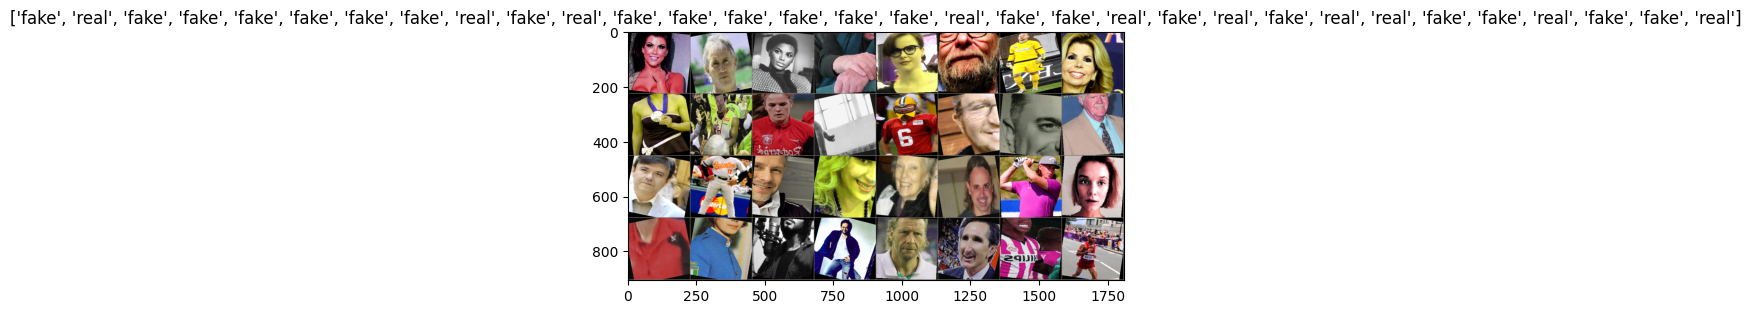

In [55]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array(IMAGENET_MEAN)
    std = np.array(IMAGENET_STD)
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(default_dataloader["train"]))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

## Training the Model

This function trains a deep learning model using supervised learning with PyTorch. Key steps:

- Alternates between training (updating weights) and validation (evaluating performance).
- Uses cross-entropy loss and optimizes with gradient descent.
- Tracks the best validation accuracy, saving model parameters for later use.
- Implements a learning rate scheduler for better convergence.

After training, the model is restored to its best-performing state.

In [56]:
def train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs=25, verbose=True):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, "best_model_params.pt")

        torch.save(model.state_dict(), best_model_params_path)
        best_f1 = 0.0

        # Store loss, accuracy and f1 values
        history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": [], 
                  "train_f1": [], "val_f1": []}

        for epoch in range(num_epochs):
            if verbose:
                print(f"Epoch {epoch}/{num_epochs - 1}")
                print("-" * 10)

            # Each epoch has a training and validation phase
            for phase in ["train", "val"]:
                if phase == "train":
                    model.train()  # Set model to training mode
                else:
                    model.eval()  # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0
                all_preds = []
                all_labels = []
                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == "train"):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == "train":
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)

                    # Collect predictions and labels for F1 score
                    all_preds.extend(preds.tolist())
                    all_labels.extend(labels.tolist())

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                if phase == "train" and scheduler is not None:
                    if type(scheduler) is lr_scheduler.ReduceLROnPlateau:
                        scheduler.step(epoch_loss)
                    else:
                        scheduler.step()

                # Convert lists to numpy arrays for sklearn
                all_preds = np.array(all_preds)
                all_labels = np.array(all_labels)

                # Calculate F1 score (using weighted average due to class imbalance)
                epoch_f1 = f1_score(all_labels, all_preds, average='weighted')

                # Store metrics in history
                history[f"{phase}_loss"].append(epoch_loss)
                history[f"{phase}_acc"].append(epoch_acc.item())
                history[f"{phase}_f1"].append(epoch_f1)

                if verbose:
                    print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} F1: {epoch_f1:.4f}")

                # deep copy the model (using F1 score as the criterion for best model)
                if phase == "val" and epoch_f1 > best_f1:
                    best_f1 = epoch_f1
                    torch.save(model.state_dict(), best_model_params_path)

            if verbose:
                print()

        time_elapsed = time.time() - since
        print(
            f"Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s"
        )
        if verbose:
            print(f"Best val F1: {best_f1:4f}")

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path, weights_only=True))
    return model, history

## Evaluating Model Predictions

This function visualizes the model’s predictions on validation data:

- The model switches to evaluation mode to disable weight updates.
- Images and predicted labels are displayed alongside ground truth data.
- Helps assess model performance qualitatively by identifying correct and incorrect classifications.

This provides an intuitive check on how well the model generalizes to unseen data.

In [57]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(default_dataloader["val"]):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 2, 2, images_so_far)
                ax.axis("off")
                ax.set_title(f"predicted: {class_names[preds[j]]}")
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

## Defining and Optimizing the Model

In this step, we initialize a ResNet-18 model pre-trained on ImageNet (IMAGENET1K_V1) and adapt it for our binary classification task (real vs. fake images). The final fully connected (fc) layer is replaced with a new linear layer that outputs two classes.

We define:
- Loss Function: CrossEntropyLoss, commonly used for classification tasks.
- Optimizer: Stochastic Gradient Descent (SGD) with momentum (0.9) to improve convergence.
- Learning Rate Scheduler: The learning rate decays by a factor of 0.1 every 7 epochs to enhance model stability during training.

In [58]:
model_base = models.resnet18()
num_ftrs = model_base.fc.in_features

# Here the size of each output sample is set to 2.
model_base.fc = nn.Linear(num_ftrs, 2)

model_base = model_base.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_base = optim.SGD(model_base.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_base, step_size=7, gamma=0.1)

In [59]:
model_base, epoch_results_base = train_model(
    model_base, dataloaders["no_augmentation"], criterion, optimizer_base, exp_lr_scheduler, num_epochs=10
)

Epoch 0/9
----------
train Loss: 0.5849 Acc: 0.7435 F1: 0.6394
val Loss: 0.5585 Acc: 0.7492 F1: 0.6417

Epoch 1/9
----------
train Loss: 0.5660 Acc: 0.7468 F1: 0.6430
val Loss: 0.5499 Acc: 0.7492 F1: 0.6417

Epoch 2/9
----------
train Loss: 0.5460 Acc: 0.7428 F1: 0.6466
val Loss: 0.5560 Acc: 0.7508 F1: 0.6457

Epoch 3/9
----------
train Loss: 0.5260 Acc: 0.7534 F1: 0.6708
val Loss: 0.5278 Acc: 0.7508 F1: 0.6933

Epoch 4/9
----------
train Loss: 0.5100 Acc: 0.7541 F1: 0.6863
val Loss: 0.5710 Acc: 0.7525 F1: 0.6782

Epoch 5/9
----------
train Loss: 0.4809 Acc: 0.7705 F1: 0.7243
val Loss: 0.5979 Acc: 0.6973 F1: 0.7061

Epoch 6/9
----------
train Loss: 0.4648 Acc: 0.7741 F1: 0.7333
val Loss: 0.5378 Acc: 0.7324 F1: 0.6904

Epoch 7/9
----------
train Loss: 0.4119 Acc: 0.8069 F1: 0.7731
val Loss: 0.5124 Acc: 0.7559 F1: 0.7215

Epoch 8/9
----------
train Loss: 0.3930 Acc: 0.8135 F1: 0.7831
val Loss: 0.5126 Acc: 0.7458 F1: 0.7163

Epoch 9/9
----------
train Loss: 0.3853 Acc: 0.8273 F1: 0.8031
v

In [60]:
model_ft = models.resnet18(weights="IMAGENET1K_V1")
num_ftrs = model_ft.fc.in_features

# Here the size of each output sample is set to 2.
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

## Training the Model

Now, we train our fine-tuned ResNet-18 model using the previously defined optimizer, loss function, and learning rate scheduler. The model will adjust its weights based on our dataset.

Note: In the original tutorial, the model is trained for 25 epochs, but since we are using more images than the tutorial and training on a CPU, I set it to just 1 epoch to keep runtime around 12 minutes.

In [61]:
model_ft, epoch_results_ft = train_model(
    model_ft, dataloaders["no_augmentation"], criterion, optimizer_ft, exp_lr_scheduler, num_epochs=10
)

Epoch 0/9
----------
train Loss: 0.5601 Acc: 0.7362 F1: 0.6769
val Loss: 0.5245 Acc: 0.7391 F1: 0.7403

Epoch 1/9
----------
train Loss: 0.3976 Acc: 0.8288 F1: 0.8132
val Loss: 0.4198 Acc: 0.7977 F1: 0.7832

Epoch 2/9
----------
train Loss: 0.2591 Acc: 0.9002 F1: 0.8974
val Loss: 0.4264 Acc: 0.8177 F1: 0.7962

Epoch 3/9
----------
train Loss: 0.1656 Acc: 0.9450 F1: 0.9440
val Loss: 0.4047 Acc: 0.8127 F1: 0.8157

Epoch 4/9
----------
train Loss: 0.0854 Acc: 0.9803 F1: 0.9803
val Loss: 0.3914 Acc: 0.8328 F1: 0.8320

Epoch 5/9
----------
train Loss: 0.0479 Acc: 0.9934 F1: 0.9934
val Loss: 0.3938 Acc: 0.8311 F1: 0.8271

Epoch 6/9
----------
train Loss: 0.0281 Acc: 0.9982 F1: 0.9982
val Loss: 0.4187 Acc: 0.8244 F1: 0.8242

Epoch 7/9
----------
train Loss: 0.0190 Acc: 1.0000 F1: 1.0000
val Loss: 0.4149 Acc: 0.8261 F1: 0.8227

Epoch 8/9
----------
train Loss: 0.0170 Acc: 0.9993 F1: 0.9993
val Loss: 0.4231 Acc: 0.8328 F1: 0.8246

Epoch 9/9
----------
train Loss: 0.0181 Acc: 0.9993 F1: 0.9993
v

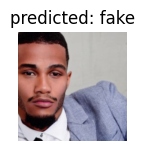

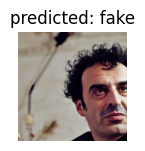

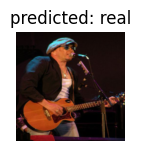

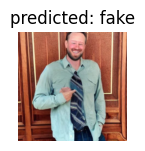

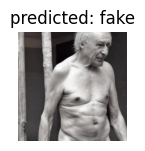

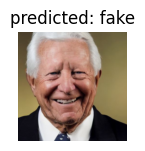

In [62]:
visualize_model(model_ft)

## Feature Extraction with ResNet-18

Instead of fine-tuning all ResNet-18 layers, we freeze the pre-trained weights (requires_grad = False) and only train the final fully connected layer for binary classification. This approach, known as feature extraction, is useful when we have a smaller dataset and want to leverage pre-trained features.

- Only the final layer is optimized, making training more efficient.
- We still use SGD with momentum and a learning rate scheduler to optimize training.

This method ensures we benefit from ResNet’s powerful pre-trained features while reducing the computational cost of training. 

In [63]:
model_conv = torchvision.models.resnet18(weights="IMAGENET1K_V1")
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [64]:
model_conv, epoch_results_conv = train_model(
    model_conv, dataloaders["no_augmentation"], criterion, optimizer_conv, exp_lr_scheduler, num_epochs=10
)

Epoch 0/9
----------
train Loss: 0.6173 Acc: 0.7086 F1: 0.6657
val Loss: 0.5599 Acc: 0.7090 F1: 0.6876

Epoch 1/9
----------
train Loss: 0.5126 Acc: 0.7537 F1: 0.7076
val Loss: 0.5185 Acc: 0.7508 F1: 0.6771

Epoch 2/9
----------
train Loss: 0.4903 Acc: 0.7654 F1: 0.7284
val Loss: 0.4995 Acc: 0.7475 F1: 0.7188

Epoch 3/9
----------
train Loss: 0.4642 Acc: 0.7825 F1: 0.7516
val Loss: 0.4883 Acc: 0.7625 F1: 0.7225

Epoch 4/9
----------
train Loss: 0.4521 Acc: 0.7898 F1: 0.7595
val Loss: 0.4880 Acc: 0.7709 F1: 0.7509

Epoch 5/9
----------
train Loss: 0.4556 Acc: 0.7880 F1: 0.7621
val Loss: 0.4789 Acc: 0.7742 F1: 0.7381

Epoch 6/9
----------
train Loss: 0.4468 Acc: 0.7938 F1: 0.7721
val Loss: 0.4804 Acc: 0.7726 F1: 0.7241

Epoch 7/9
----------
train Loss: 0.4289 Acc: 0.8055 F1: 0.7837
val Loss: 0.4741 Acc: 0.7742 F1: 0.7406

Epoch 8/9
----------
train Loss: 0.4292 Acc: 0.8018 F1: 0.7810
val Loss: 0.4737 Acc: 0.7776 F1: 0.7469

Epoch 9/9
----------
train Loss: 0.4306 Acc: 0.8036 F1: 0.7822
v

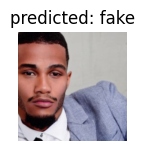

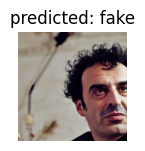

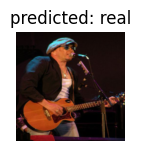

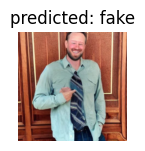

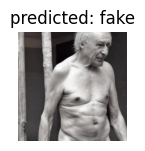

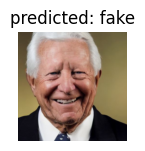

In [65]:
visualize_model(model_conv)

plt.ioff()
plt.show()

## Visualizing Model Predictions

This function allows us to visualize the model’s prediction for a given image. It follows these steps:

- Loads the image and applies the same transformations used during validation.
- Converts the image into a format suitable for the model (unsqueeze(0) to add batch dimension).
- Disables gradient computation (torch.no_grad()) for efficient inference.
- Predicts the class and displays the image with its predicted label.

This function helps us qualitatively evaluate the model’s performance by seeing its predictions on real examples.

In [66]:
def visualize_model_predictions(model, img_path):
    was_training = model.training
    model.eval()

    img = Image.open(img_path)
    img = basic_transform(img)
    img = img.unsqueeze(0)
    img = img.to(device)

    with torch.no_grad():
        outputs = model(img)
        _, preds = torch.max(outputs, 1)

        ax = plt.subplot(2, 2, 1)
        ax.axis("off")
        ax.set_title(f"Predicted: {class_names[preds[0]]}")
        imshow(img.cpu().data[0])

        model.train(mode=was_training)

## Running the Visualization on a Sample Image

Here, we test our trained feature extraction model (model_conv) by passing a real image from the validation set. The model's prediction is displayed alongside the image.

Note: Ensure that the input image is not grayscale. The function expects an RGB image (3 channels), and passing a single-channel grayscale image may lead to errors or unexpected behavior.

In [67]:
# visualize_model_predictions(
#     model_conv, img_path="resized_data/val/fake/50745_1941-10-13_2011.jpg"
# )

plt.ioff()
plt.show()

## Plotting Classification Performance

In [68]:
def plot_training_history(history, title_label=""):
    if title_label != "":
        title_label = f": {title_label}"
    epochs = range(len(history["train_loss"]))

    plt.figure(figsize=(12, 5))

    # Loss Plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history["train_loss"], label="Train Loss")
    plt.plot(epochs, history["val_loss"], label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")

    plt.title(f"Training & Validation Loss{title_label}")
    plt.legend()

    # F1 Plot
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history["train_f1"], label="Train F1")
    plt.plot(epochs, history["val_f1"], label="Validation F1")
    plt.xlabel("Epochs")
    plt.ylabel("F1 Score")
    plt.title(f"Training & Validation F1 Score{title_label}")
    plt.legend()


    plt.show()

In [69]:
def test_model(model):
    """
    Evaluates the model on the test dataset and returns accuracy and F1 score.
    
    Args:
        model (torch.nn.Module): Trained PyTorch model.
    Returns:
        dict: A dictionary containing accuracy and F1 score.
    """
    model.eval()  # Set model to evaluation mode
    running_corrects = 0
    all_preds = []
    all_labels = []
    dataloader = default_dataloader["test"]

    with torch.no_grad():  # No need to track gradients during evaluation
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            running_corrects += torch.sum(preds == labels.data)
            all_preds.extend(preds.tolist())
            all_labels.extend(labels.tolist())

    # Compute accuracy
    dataset_size = len(dataloader.dataset)
    accuracy = running_corrects.double() / dataset_size

    # Compute F1-score
    f1 = f1_score(np.array(all_labels), np.array(all_preds), average='weighted')

    # print(f"Test Accuracy: {accuracy:.4f}, Test F1 Score: {f1:.4f}")
    
    return {"acc": accuracy.item(), "f1_score": f1}

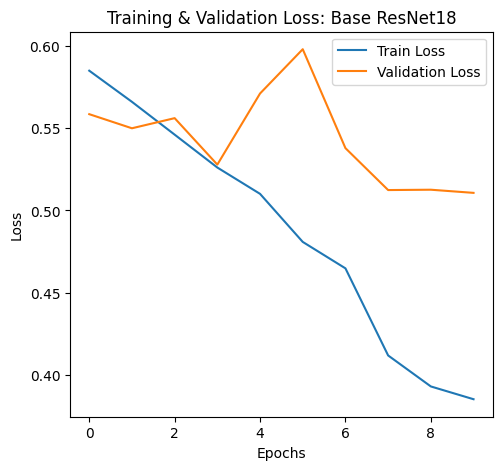

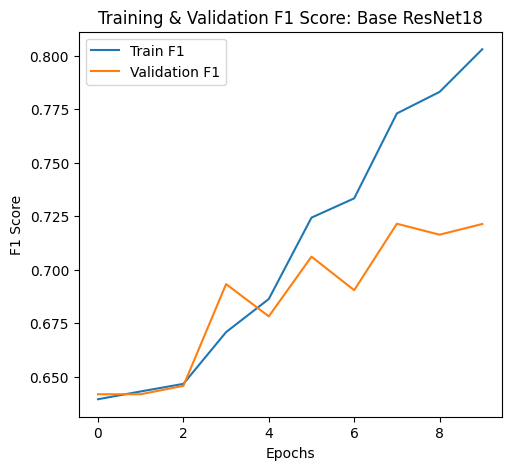

In [70]:
plot_training_history(epoch_results_base, "Base ResNet18")

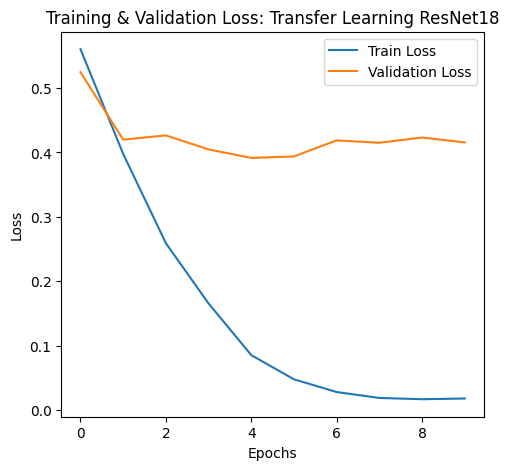

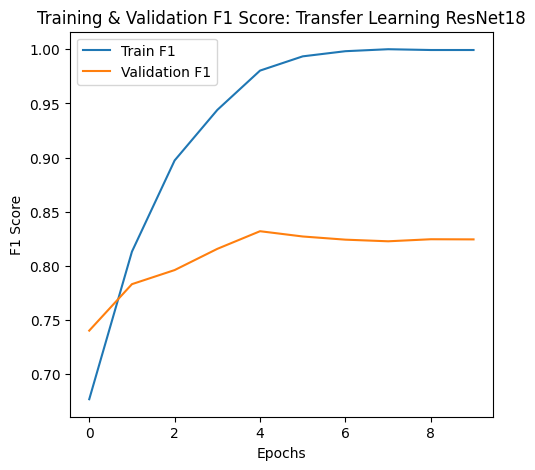

In [71]:
plot_training_history(epoch_results_ft, "Transfer Learning ResNet18")

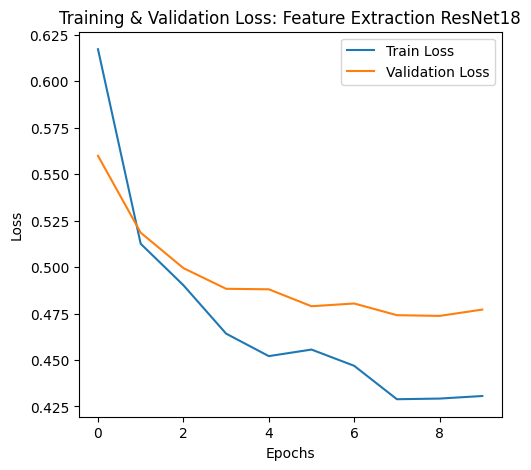

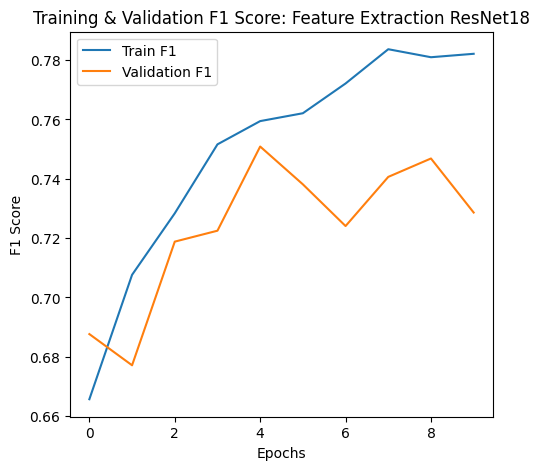

In [72]:
plot_training_history(epoch_results_conv, "Feature Extraction ResNet18")

In [73]:
test_model(model_base)

{'acc': 0.7353433835845896, 'f1_score': 0.7034184762758984}

In [74]:
test_model(model_conv)

{'acc': 0.7537688442211056, 'f1_score': 0.7405185739467193}

In [75]:
test_model(model_ft)

{'acc': 0.8257956448911223, 'f1_score': 0.8237556411903889}

In [76]:
model_ft = models.resnet18(weights="IMAGENET1K_V1")
num_ftrs = model_ft.fc.in_features

model_ft_data_augmented = models.resnet18(weights="IMAGENET1K_V1")
num_ftrs = model_ft_data_augmented.fc.in_features

# Here the size of each output sample is set to 2.
model_ft_data_augmented.fc = nn.Linear(num_ftrs, 2)

model_ft_data_augmented = model_ft_data_augmented.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft_augmented = optim.SGD(model_ft_data_augmented.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft_augmented, step_size=7, gamma=0.1)

model_ft_augmented, epoch_results_ft_augmented = train_model(
    model_ft_data_augmented, dataloaders["augmentation"], criterion, optimizer_ft_augmented, exp_lr_scheduler, num_epochs=10
)

Epoch 0/9
----------
train Loss: 0.5888 Acc: 0.7246 F1: 0.6672
val Loss: 0.5392 Acc: 0.7458 F1: 0.6545

Epoch 1/9
----------
train Loss: 0.4955 Acc: 0.7610 F1: 0.7206
val Loss: 0.4913 Acc: 0.7742 F1: 0.7187

Epoch 2/9
----------
train Loss: 0.4767 Acc: 0.7785 F1: 0.7593
val Loss: 0.4432 Acc: 0.8027 F1: 0.7842

Epoch 3/9
----------
train Loss: 0.4483 Acc: 0.7978 F1: 0.7795
val Loss: 0.4413 Acc: 0.7943 F1: 0.7859

Epoch 4/9
----------
train Loss: 0.4349 Acc: 0.8080 F1: 0.7946
val Loss: 0.4239 Acc: 0.7977 F1: 0.7894

Epoch 5/9
----------
train Loss: 0.4289 Acc: 0.8066 F1: 0.7920
val Loss: 0.4220 Acc: 0.8010 F1: 0.7703

Epoch 6/9
----------
train Loss: 0.4066 Acc: 0.8113 F1: 0.8001
val Loss: 0.4378 Acc: 0.7977 F1: 0.7924

Epoch 7/9
----------
train Loss: 0.3739 Acc: 0.8372 F1: 0.8280
val Loss: 0.4169 Acc: 0.8077 F1: 0.7932

Epoch 8/9
----------
train Loss: 0.3634 Acc: 0.8383 F1: 0.8296
val Loss: 0.4078 Acc: 0.8127 F1: 0.7989

Epoch 9/9
----------
train Loss: 0.3694 Acc: 0.8284 F1: 0.8183
v

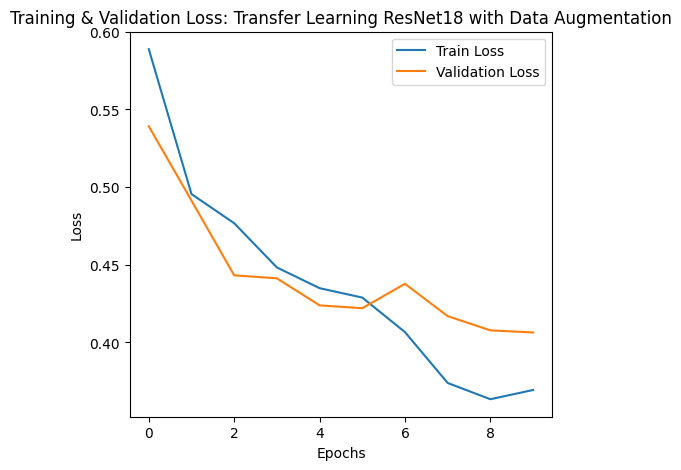

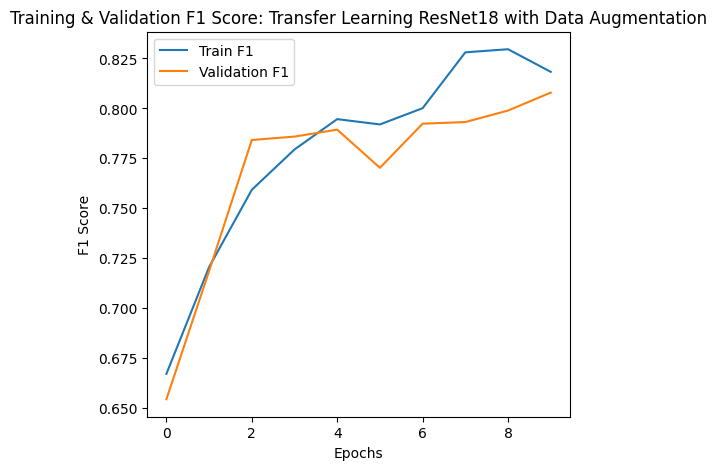

In [77]:
plot_training_history(epoch_results_ft_augmented, "Transfer Learning ResNet18 with Data Augmentation")

In [78]:
model_efficient_net_ft = models.efficientnet_v2_s(weights=models.EfficientNet_V2_S_Weights.IMAGENET1K_V1)

# Freeze feature extractor layers (transfer learning)
freeze_layers = False  # Set to True if you only want to train the classifier

if freeze_layers:
    for param in model_efficient_net_ft.features.parameters():
        param.requires_grad = False

# Get the number of input features for the classifier layer
num_ftrs = model_efficient_net_ft.classifier[1].in_features

# Replace the classifier layer with a new one that has 2 output features (for binary classification)
model_efficient_net_ft.classifier[1] = nn.Linear(num_ftrs, 2)

# Move model to the appropriate device (GPU if available, otherwise CPU)
model_efficient_net_ft = model_efficient_net_ft.to(device)

# Define the loss function (CrossEntropyLoss for classification)
criterion = nn.CrossEntropyLoss()

# Define the optimizer
optimizer_efficient_net_ft = optim.Adam(model_efficient_net_ft.parameters(), lr=0.0001) 

# Define a learning rate scheduler that decays the learning rate by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [79]:
model_efficient_net_ft, epoch_results_efficient_net = train_model(
    model_efficient_net_ft, dataloaders["augmentation"], criterion, optimizer_efficient_net_ft, exp_lr_scheduler, num_epochs=15
)

Epoch 0/14
----------
train Loss: 0.5536 Acc: 0.7180 F1: 0.6725
val Loss: 0.4961 Acc: 0.7425 F1: 0.6927

Epoch 1/14
----------
train Loss: 0.4381 Acc: 0.7953 F1: 0.7768
val Loss: 0.4356 Acc: 0.7893 F1: 0.7852

Epoch 2/14
----------
train Loss: 0.3723 Acc: 0.8386 F1: 0.8335
val Loss: 0.3705 Acc: 0.8227 F1: 0.8231

Epoch 3/14
----------
train Loss: 0.3388 Acc: 0.8470 F1: 0.8436
val Loss: 0.4017 Acc: 0.7910 F1: 0.7991

Epoch 4/14
----------
train Loss: 0.2819 Acc: 0.8805 F1: 0.8778
val Loss: 0.3468 Acc: 0.8462 F1: 0.8458

Epoch 5/14
----------
train Loss: 0.2641 Acc: 0.8933 F1: 0.8911
val Loss: 0.3475 Acc: 0.8545 F1: 0.8490

Epoch 6/14
----------
train Loss: 0.2448 Acc: 0.8965 F1: 0.8952
val Loss: 0.3499 Acc: 0.8579 F1: 0.8520

Epoch 7/14
----------
train Loss: 0.2036 Acc: 0.9155 F1: 0.9146
val Loss: 0.3540 Acc: 0.8662 F1: 0.8618

Epoch 8/14
----------
train Loss: 0.2005 Acc: 0.9228 F1: 0.9222
val Loss: 0.4087 Acc: 0.8077 F1: 0.8144

Epoch 9/14
----------
train Loss: 0.1695 Acc: 0.9344 F1

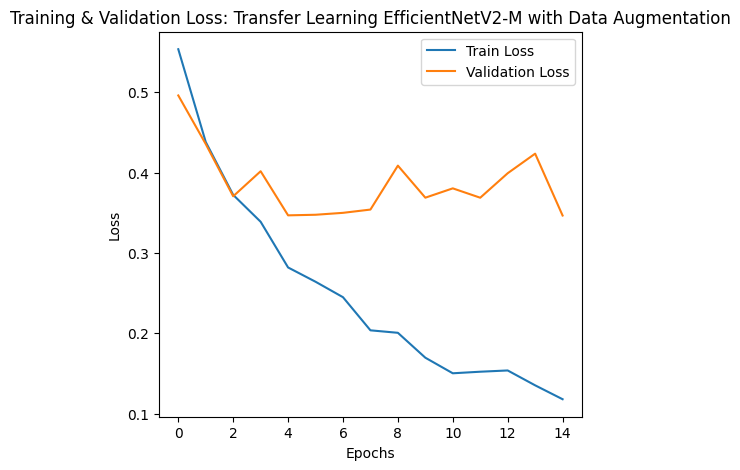

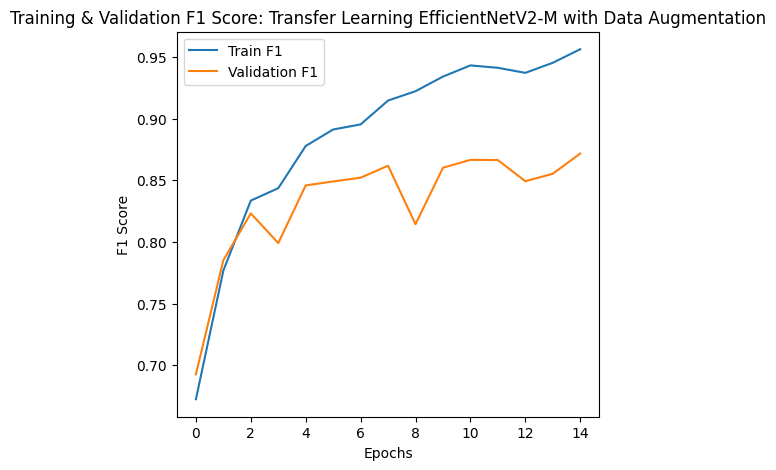

In [ ]:
plot_training_history(epoch_results_efficient_net, "Transfer Learning EfficientNetV2-S with Data Augmentation")

In [81]:
model_vit_ft = models.vit_b_16(weights=models.ViT_B_16_Weights.IMAGENET1K_V1)

# Freeze feature extractor layers (transfer learning)
freeze_layers = False  # Set to True if you only want to train the classifier

if freeze_layers:
    for param in model_vit_ft.parameters():
        param.requires_grad = False

# Get the number of input features for the classifier layer
num_ftrs = model_vit_ft.heads.head.in_features

# Replace the classifier layer with a new one that has 2 output features (for binary classification)
model_vit_ft.heads.head = nn.Linear(num_ftrs, 2)

# Move model to the appropriate device (GPU if available, otherwise CPU)
model_vit_ft = model_vit_ft.to(device)

# Define the loss function (CrossEntropyLoss for classification)
criterion = nn.CrossEntropyLoss()

# Define the optimizer
optimizer_ft = optim.Adam(model_vit_ft.parameters(), lr=0.0001)

# Define a learning rate scheduler that decays the learning rate by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [82]:
model_vit_ft, epoch_results_vit_ft = train_model(
    model_vit_ft, dataloaders["augmentation"], criterion, optimizer_ft, exp_lr_scheduler, num_epochs=15
)

Epoch 0/14
----------
train Loss: 0.5705 Acc: 0.7377 F1: 0.6529
val Loss: 0.5372 Acc: 0.7492 F1: 0.6417

Epoch 1/14
----------
train Loss: 0.5318 Acc: 0.7435 F1: 0.6632
val Loss: 0.5152 Acc: 0.7358 F1: 0.7132

Epoch 2/14
----------
train Loss: 0.5448 Acc: 0.7501 F1: 0.6748
val Loss: 0.5096 Acc: 0.7692 F1: 0.7078

Epoch 3/14
----------
train Loss: 0.5051 Acc: 0.7497 F1: 0.7037
val Loss: 0.5283 Acc: 0.7609 F1: 0.6787

Epoch 4/14
----------
train Loss: 0.4803 Acc: 0.7709 F1: 0.7348
val Loss: 0.5311 Acc: 0.7140 F1: 0.7262

Epoch 5/14
----------
train Loss: 0.4744 Acc: 0.7712 F1: 0.7391
val Loss: 0.4737 Acc: 0.7625 F1: 0.7532

Epoch 6/14
----------
train Loss: 0.4670 Acc: 0.7774 F1: 0.7487
val Loss: 0.5301 Acc: 0.7090 F1: 0.7034

Epoch 7/14
----------
train Loss: 0.4110 Acc: 0.8113 F1: 0.7987
val Loss: 0.4550 Acc: 0.7742 F1: 0.7536

Epoch 8/14
----------
train Loss: 0.3446 Acc: 0.8444 F1: 0.8375
val Loss: 0.4802 Acc: 0.7876 F1: 0.7909

Epoch 9/14
----------
train Loss: 0.3251 Acc: 0.8597 F1

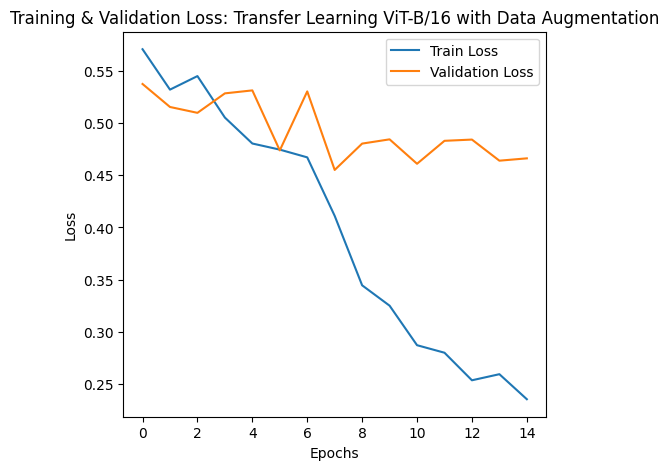

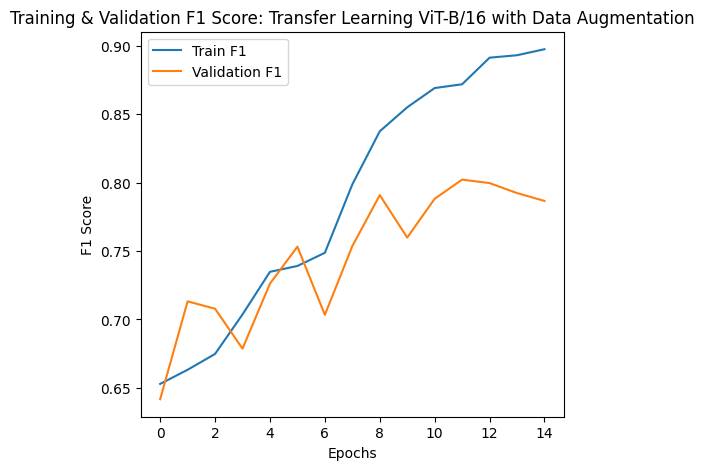

In [83]:
plot_training_history(epoch_results_vit_ft, "Transfer Learning ViT-B/16 with Data Augmentation")

#### Improve learning rate decay and attempt to reduce training instability
- Use Adam optimizer
- Use different learning rates

In [90]:
def get_plot_location(filename):
    return os.path.join("plots", filename)

def plot_hyperparameter_results(results, model_name):
    """
    Plot the results of hyperparameter tuning
    
    Args:
        results: List of result dictionaries from hyperparameter tuning
    """
    # Sort results by validation F1 score
    sorted_results = sorted(results, key=lambda x: x['val_f1'], reverse=True)

    # 1. Bar plot comparing all configurations by F1 score
    plt.figure(figsize=(14, 8))

    configs = [f"{r['criterion']}\n{r['optimizer']}\n{r['scheduler']}\n{r['lr']}" for r in sorted_results]
    f1_scores = [r['val_f1'] for r in sorted_results]

    bars = plt.bar(range(len(configs)), f1_scores)

    # Color the best configuration differently
    bars[0].set_color('green')

    plt.xticks(range(len(configs)), configs, rotation=90, ha='right')
    plt.xlabel('Hyperparameter Configuration')
    plt.ylabel('Best Validation F1 Score')
    plt.title('Hyperparameter Configurations Ranked by F1 Score')
    plt.tight_layout()
    plt.savefig(get_plot_location(f'hyperparameter_rankings_{model_name}.png'))
    plt.show()

    # 2. Learning curves of top 3 models
    plt.figure(figsize=(16, 12))

    for i, result in enumerate(sorted_results[:min(3, len(sorted_results))]):
        config_name = f"{result['criterion']} + {result['optimizer']} + {result['scheduler']}"

        plt.subplot(3, 2, i*2+1)
        plt.plot(result['history']['train_loss'], label='Train Loss')
        plt.plot(result['history']['val_loss'], label='Validation Loss')
        plt.title(f"Top {i+1}: {config_name} - Loss")
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

        plt.subplot(3, 2, i*2+2)
        plt.plot(result['history']['train_f1'], label='Train F1')
        plt.plot(result['history']['val_f1'], label='Validation F1')
        plt.title(f"Top {i+1}: {config_name} - F1 Score")
        plt.xlabel('Epoch')
        plt.ylabel('F1 Score')
        plt.legend()

    plt.tight_layout()
    plt.savefig(get_plot_location(f'top_model_learning_curves_{model_name}.png'))
    plt.show()

    # 3. Optimizer comparison
    plt.figure(figsize=(12, 6))
    
    optimizer_groups = {}
    for r in results:
        if r['optimizer'] not in optimizer_groups:
            optimizer_groups[r['optimizer']] = []
        optimizer_groups[r['optimizer']].append(r['val_f1'])
    
    optimizers = list(optimizer_groups.keys())
    avg_f1 = [np.mean(optimizer_groups[opt]) for opt in optimizers]
    max_f1 = [np.max(optimizer_groups[opt]) for opt in optimizers]
    
    x = np.arange(len(optimizers))
    width = 0.35
    
    plt.bar(x - width/2, avg_f1, width, label='Average F1')
    plt.bar(x + width/2, max_f1, width, label='Best F1')
    
    plt.xticks(x, optimizers)
    plt.xlabel('Optimizer')
    plt.ylabel('F1 Score')
    plt.title('Optimizer Performance Comparison')
    plt.legend()
    plt.savefig(get_plot_location(f'optimizer_comparison_{model_name}.png'))
    plt.show()

    # 4. Criterion comparison
    plt.figure(figsize=(12, 6))
    
    criterion_groups = {}
    for r in results:
        if r['criterion'] not in criterion_groups:
            criterion_groups[r['criterion']] = []
        criterion_groups[r['criterion']].append(r['val_f1'])
    
    criterions = list(criterion_groups.keys())
    avg_f1 = [np.mean(criterion_groups[crit]) for crit in criterions]
    max_f1 = [np.max(criterion_groups[crit]) for crit in criterions]
    
    x = np.arange(len(criterions))
    
    plt.bar(x - width/2, avg_f1, width, label='Average F1')
    plt.bar(x + width/2, max_f1, width, label='Best F1')
    
    plt.xticks(x, criterions)
    plt.xlabel('Loss Function')
    plt.ylabel('F1 Score')
    plt.title('Loss Function Performance Comparison')
    plt.legend()
    plt.savefig(get_plot_location(f'criterion_comparison_{model_name}.png'))
    plt.show()
    
    # 5. Scheduler comparison
    plt.figure(figsize=(12, 6))

    scheduler_groups = {}
    for r in results:
        if r['scheduler'] not in scheduler_groups:
            scheduler_groups[r['scheduler']] = []
        scheduler_groups[r['scheduler']].append(r['val_f1'])
    
    schedulers = list(scheduler_groups.keys())
    avg_f1 = [np.mean(scheduler_groups[sched]) for sched in schedulers]
    max_f1 = [np.max(scheduler_groups[sched]) for sched in schedulers]
    
    x = np.arange(len(schedulers))
    
    plt.bar(x - width/2, avg_f1, width, label='Average F1')
    plt.bar(x + width/2, max_f1, width, label='Best F1')
    
    plt.xticks(x, schedulers)
    plt.xlabel('Scheduler')
    plt.ylabel('F1 Score')
    plt.title('Scheduler Performance Comparison')
    plt.legend()
    plt.savefig(get_plot_location(f'scheduler_comparison_{model_name}.png'))
    plt.show()

## Hyperparameter Tuning
We use data augmentation here, as opposed to before on the simple training examples. The performance is much better with data augmentation, so we decided not to tune without it (just a waste of computational resources).

In [91]:
def hyperparameter_tuning(get_model, num_epochs=25):
    """Tune hyperparameters and return the best model."""
    criterion_options = {
        "CE": nn.CrossEntropyLoss(),
        "Weighted CE": nn.CrossEntropyLoss(weight=class_weights.to(device)),
    }
    optimizer_options = {
        "sgd":
            lambda params, lr: optim.SGD(params, lr=lr, momentum=0.9),
        "adam":
            lambda params, lr: optim.Adam(params, lr=lr, betas=(0.9, 0.999)),
    }
    scheduler_options = {
        "step_lr":
            lambda opt: lr_scheduler.StepLR(opt, step_size=7, gamma=0.1),
        "plateau_lr":
            lambda opt: lr_scheduler.ReduceLROnPlateau(opt, mode='min', factor=0.1, patience=7),
    }
    learning_rate = [0.001, 0.0001]

    # Generate all combinations
    param_combinations = []
    for criterion_name, criterion in criterion_options.items():
        for opt_name, opt_fn in optimizer_options.items():
            for sched_name, sched_fn in scheduler_options.items():
                for lr in learning_rate:
                    param_combinations.append({
                        'lr': lr,
                        'criterion_name': criterion_name,
                        'criterion': criterion,
                        'opt_name': opt_name,
                        'opt_fn': opt_fn,
                        'sched_name': sched_name,
                        'sched_fn': sched_fn
                    })
    print(f"Total combinations to try: {len(param_combinations)}")

    best_f1 = 0.0
    best_model = None
    best_params = None
    histories = []
    results = []

    for i, params in enumerate(param_combinations):
        # Extract parameters
        criterion_name = params['criterion_name']
        criterion = params['criterion']
        opt_name = params['opt_name']
        opt_fn = params['opt_fn']
        sched_name = params['sched_name']
        sched_fn = params['sched_fn']
        lr = params['lr']

        # Initialize fresh model
        model, model_params = get_model()
        optimizer = opt_fn(model_params, lr)
        scheduler = sched_fn(optimizer) if sched_fn else None

        print(f"\nTrial {i+1}/{len(param_combinations)}")
        print(f"Criterion: {criterion_name}")
        print(f"Optimizer: {opt_name}")
        print(f"Scheduler: {sched_name}")

        # Train and evaluate
        trained_model, history = train_model(
            model,
            dataloaders["augmentation"],
            criterion,
            optimizer,
            scheduler,
            num_epochs=num_epochs,
            verbose=False,
        )

        val_f1 = max(history["val_f1"])  # Best validation F1 from this run
        histories.append(history)

        # Save results for plotting
        results.append({
            'lr': lr,
            'criterion': criterion_name,
            'optimizer': opt_name,
            'scheduler': sched_name,
            'val_f1': val_f1,
            'trial': i+1,
            'history': history
        })

        # Track best model
        if val_f1 > best_f1:
            best_f1 = val_f1
            best_model = trained_model
            best_params = {
                'lr': lr,
                'criterion': criterion_name, 
                'optimizer': opt_name, 
                'scheduler': sched_name
            }

        print(f"Trial {i+1} Best Val F1: {val_f1:.4f}")

    print("\nBest Hyperparameters:")
    print(f"Criterion: {best_params['criterion']}")
    print(f"Optimizer: {best_params['optimizer']}")
    print(f"Scheduler: {best_params['scheduler']}")
    print(f"Best Learning Rate: {best_params['lr']}")
    print(f"Best Validation F1: {best_f1:.4f}")

    return best_model, best_params, best_f1, results

## Models to tune
- Feature extraction from resnet18 performs much worse so it was excluded from hyperparameter tuning

In [92]:
def get_fully_trainable_resnet():
    model = models.resnet18(weights="IMAGENET1K_V1")
    num_ftrs = model.fc.in_features

    model.fc = nn.Linear(num_ftrs, 2)
    model = model.to(device)
    return model, model.parameters()

_models = {
    "Fully Trainable ResNet18": get_fully_trainable_resnet,
}

plot_results = {}
final_model = None
final_model_val_f1 = 0.0
final_model_params = None
for name, model in _models.items():
    print("\n")
    print(name)
    best_model, best_params, best_f1, tuning_results = hyperparameter_tuning(model, num_epochs=15)
    if best_f1 > final_model_val_f1:
        final_model = best_model
        final_model_val_f1 = best_f1
        final_model_params = best_params
    print(name)

    plot_results[name] = tuning_results



Fully Trainable ResNet18
Total combinations to try: 16

Trial 1/16
Criterion: CE
Optimizer: sgd
Scheduler: step_lr
Training complete in 0m 59s
Trial 1 Best Val F1: 0.8205

Trial 2/16
Criterion: CE
Optimizer: sgd
Scheduler: step_lr
Training complete in 0m 59s
Trial 2 Best Val F1: 0.6803

Trial 3/16
Criterion: CE
Optimizer: sgd
Scheduler: plateau_lr
Training complete in 0m 59s
Trial 3 Best Val F1: 0.8152

Trial 4/16
Criterion: CE
Optimizer: sgd
Scheduler: plateau_lr
Training complete in 0m 59s
Trial 4 Best Val F1: 0.7203

Trial 5/16
Criterion: CE
Optimizer: adam
Scheduler: step_lr
Training complete in 1m 1s
Trial 5 Best Val F1: 0.7821

Trial 6/16
Criterion: CE
Optimizer: adam
Scheduler: step_lr
Training complete in 1m 0s
Trial 6 Best Val F1: 0.8497

Trial 7/16
Criterion: CE
Optimizer: adam
Scheduler: plateau_lr
Training complete in 1m 0s
Trial 7 Best Val F1: 0.7773

Trial 8/16
Criterion: CE
Optimizer: adam
Scheduler: plateau_lr
Training complete in 1m 1s
Trial 8 Best Val F1: 0.8372

Tr

Fully Trainable ResNet18


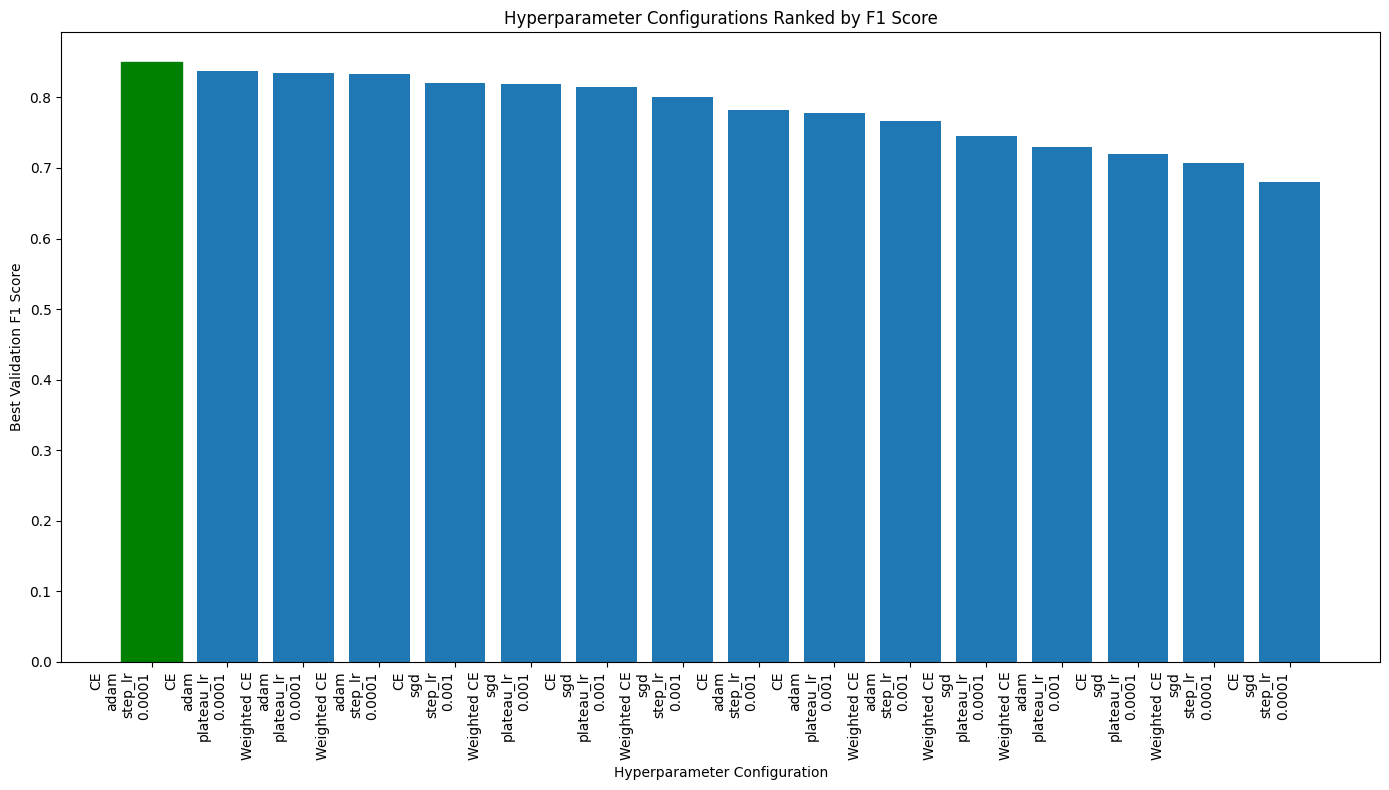

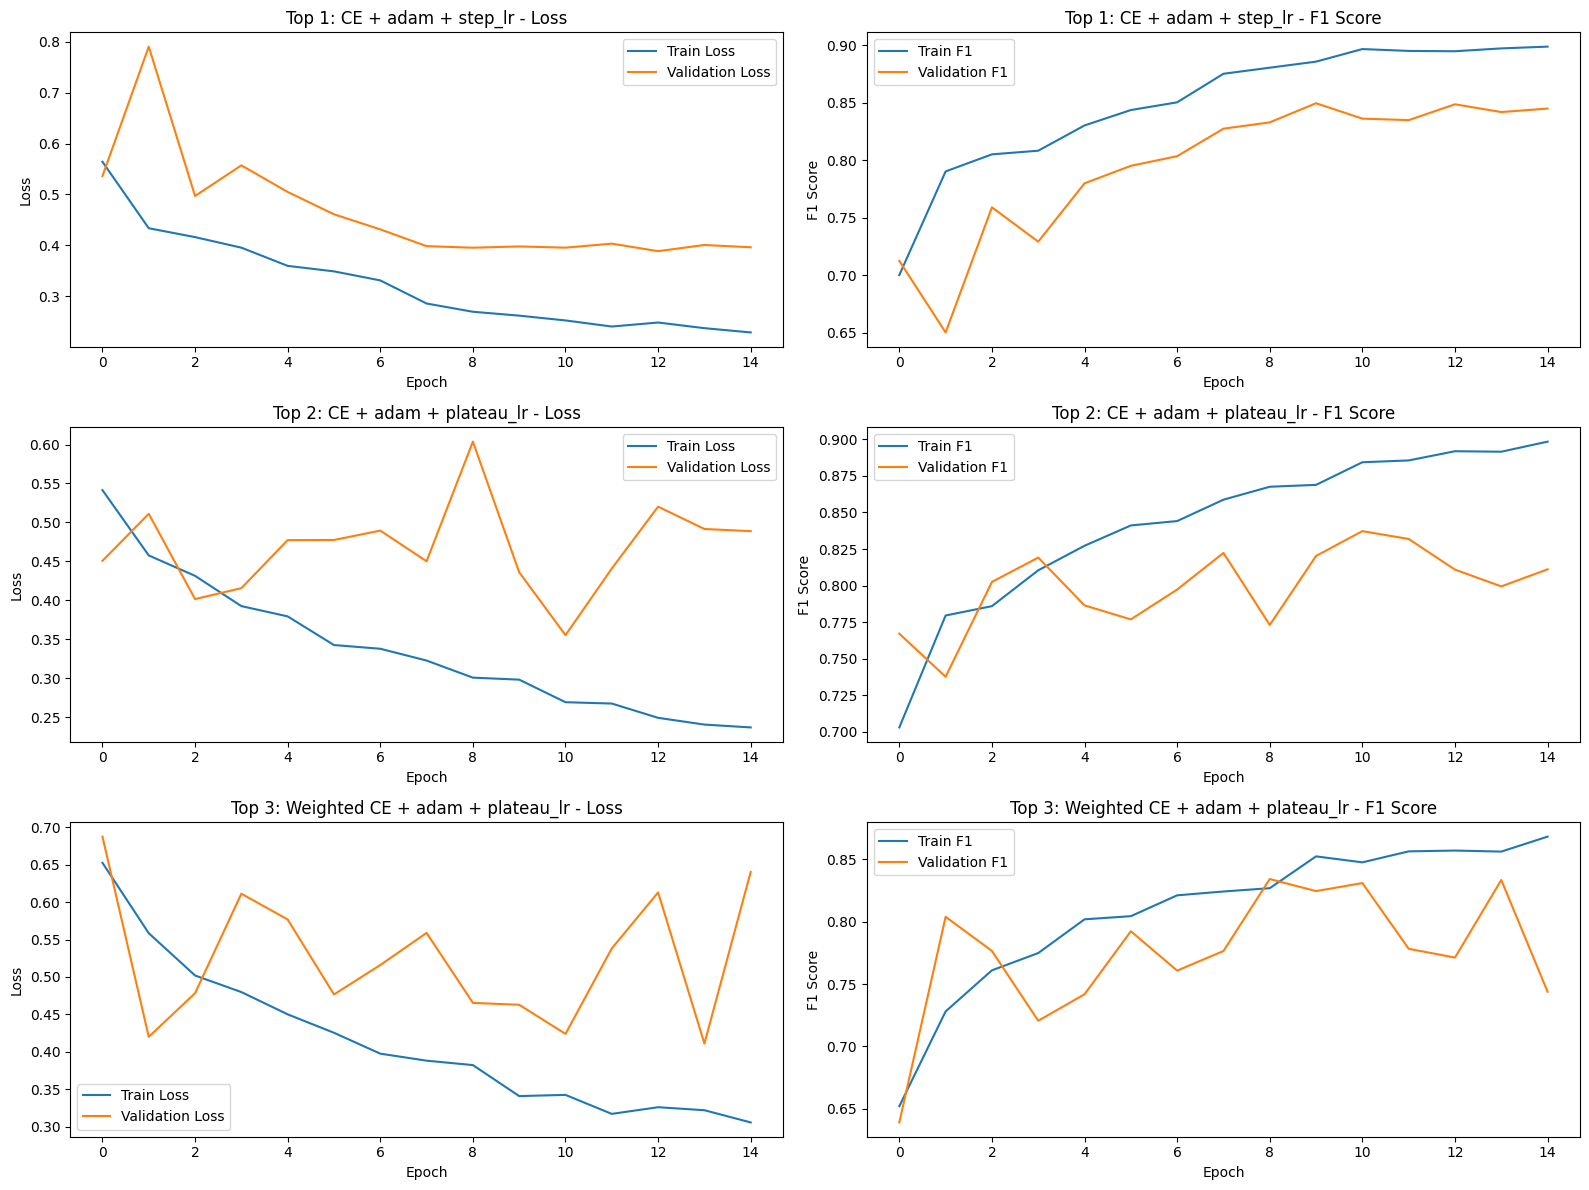

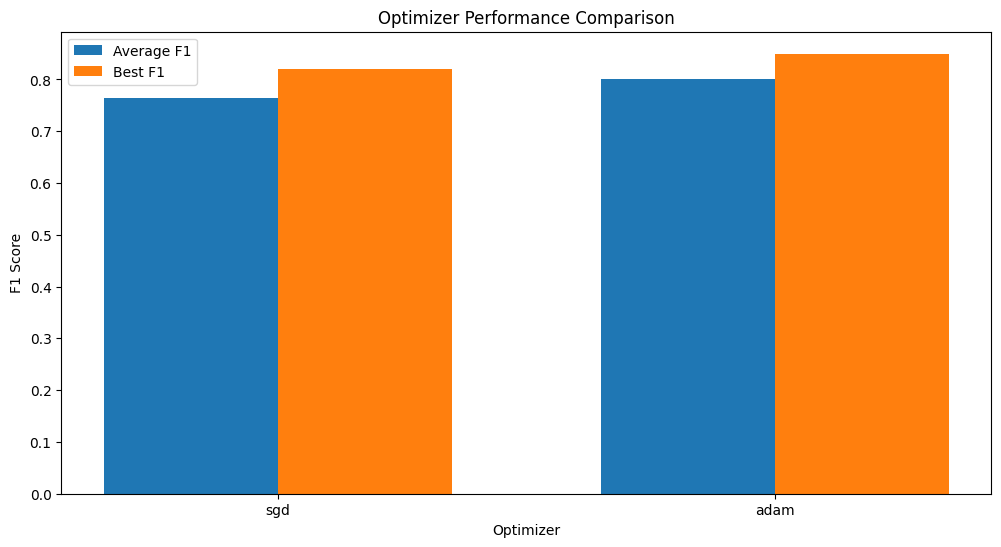

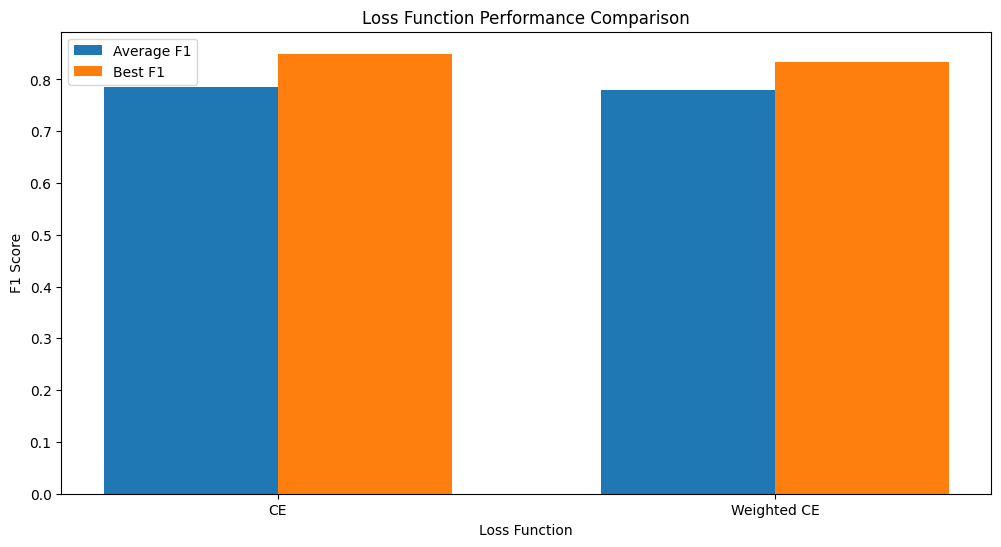

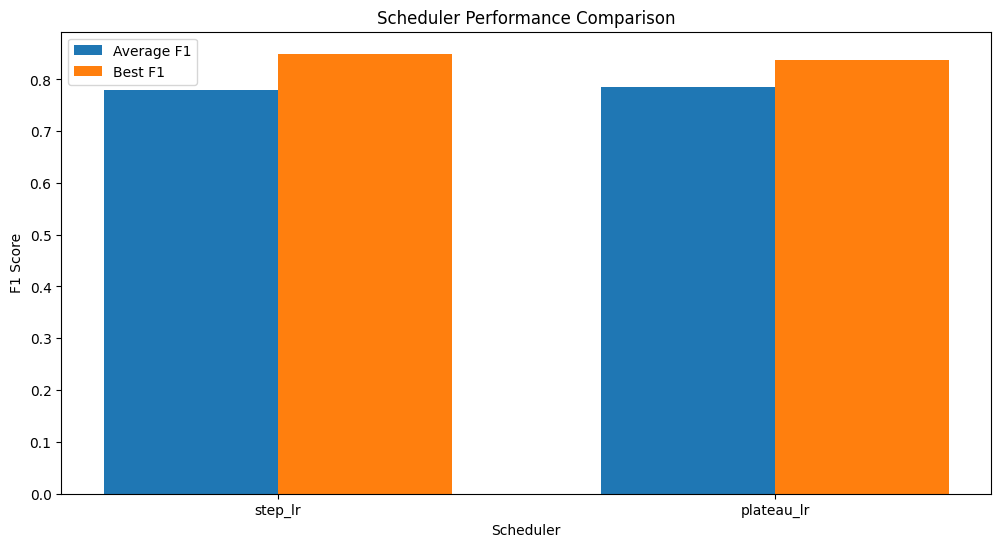

In [93]:
# Plot the results
for model_name, results in plot_results.items():
    print(model_name)
    plot_hyperparameter_results(results, model_name)

In [94]:
test_results = test_model(final_model)
print(f"Best Model: {final_model_params}")
print(f" - Best Validation F1: {final_model_val_f1:.4f}")
print(f" - Test Accuracy: {test_results['acc']:.4f}")
print(f" - Test F1 Score: {test_results['f1_score']:.4f}")

Best Model: {'lr': 0.0001, 'criterion': 'CE', 'optimizer': 'adam', 'scheduler': 'step_lr'}
 - Best Validation F1: 0.8497
 - Test Accuracy: 0.8660
 - Test F1 Score: 0.8571
